

#### This notebook initiates the development, training, and evaluation of a 2D Convolutional Neural Network (CNN) designed for hyperspectral image classification using PyTorch.

1. Environment Setup:
   - Sets up output directories for storing artifacts, figures, and model run logs. Ensures required directories exist and sets the random seeds for reproducibility.
   - Selects the computational device (GPU if available, otherwise CPU) for efficient processing.

2. Data Loading:
   - Loads the normalized hyperspectral image data cube (with dimensions Height x Width x Bands).
   - Loads the ground truth label mask, where each pixel has an associated class ID and zero indicates background.
   - Loads separate boolean masks indicating the pixels used for training, validation, and testing splits.

3. Data Overview and Preparation:
   - Determines the shape of the data and the number of classes present in the dataset.
   - Prepares the workspace for downstream operations including data handling, model definition, training, and evaluation.

The notebook forms the foundational steps for experimenting with 2D CNN architectures on hyperspectral imagery, ensuring all necessary inputs and settings are in place for reproducible machine learning workflows.




In [1]:
from pathlib import Path                                                 # import from pathlibimport time                                                              # import time libraryimport numpy as np                                                       # import numpy libraryimport matplotlib.pyplot as plt                                          # import matplotlib.pyplot library# empty lineimport torch                                                             # import torch libraryimport torch.nn as nn                                                    # import torch.nn libraryimport torch.optim as optim                                              # import torch.optim libraryfrom torch.utils.data import Dataset, DataLoader, WeightedRandomSampler  # import from torch.utils.data# empty linefrom sklearn.metrics import (                                            # import from sklearn.metrics    confusion_matrix,    accuracy_score,    precision_recall_fscore_support,    cohen_kappa_score,    classification_report,)# empty linenp.random.seed(42)torch.manual_seed(42)# empty lineARTIFACTS = Path("outputs/artifacts_ip")                                 # define path for ARTIFACTSFIGS = Path("outputs/figs")                                              # define path for FIGSRUNS = Path("outputs/runs_cnn2d_full_nodrop")                            # define path for RUNSFIGS.mkdir(parents=True, exist_ok=True)                                  # create directory FIGS.mkdir(parentsRUNS.mkdir(parents=True, exist_ok=True)                                  # create directory RUNS.mkdir(parents# empty lineDEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")    # set computation device (GPU/CPU)print("Device", DEVICE)

Device cuda


In [2]:
cube = np.load(ARTIFACTS / "cube_clean_norm.npy")           # H W Blabels = np.load(ARTIFACTS / "labels.npy")                  # H W with one based ids and zero for backgroundmask_train = np.load(ARTIFACTS / "mask_train.npy")          # H Wmask_val   = np.load(ARTIFACTS / "mask_val.npy")            # H Wmask_test  = np.load(ARTIFACTS / "mask_test.npy")           # H W# empty lineH, W, B = cube.shape                                        # assign value to H, W, Bnum_classes = int(labels.max())                             # assign value to num_classesprint("Cube", cube.shape, "Classes", num_classes)

Cube (145, 145, 200) Classes 16


In [3]:
class PatchDataset2D(Dataset):                                             # define class PatchDataset2D    def __init__(self, cube_c_last: np.ndarray, lab_map: np.ndarray, mask_map: np.ndarray, patch: int):  # define function __init__        assert patch % 2 == 1, "patch must be odd"                         # assign value to assert patch % 2        self.patch = patch                                                 # assign value to self.patch        self.rad = patch // 2                                              # assign value to self.rad        self.H, self.W, self.C = cube_c_last.shape                         # assign value to self.H, self.W, self.C        self.img = np.pad(cube_c_last.astype(np.float32),                  # assign value to self.img                          ((self.rad, self.rad), (self.rad, self.rad), (0, 0)),                          mode="reflect")                                  # assign value to mode        yy, xx = np.where(mask_map & (lab_map > 0))                        # assign value to yy, xx        self.centers = np.stack([yy, xx], axis=1)                          # assign value to self.centers        self.labels = lab_map[mask_map & (lab_map > 0)].astype(np.int64) - 1  # assign value to self.labels# empty line    def __len__(self):                                                     # define function __len__        return self.centers.shape[0]                                       # return value from function# empty line    def __getitem__(self, i):                                              # define function __getitem__        y, x = self.centers[i]                                             # assign value to y, x        yp, xp = y + self.rad, x + self.rad                                # assign value to yp, xp        patch = self.img[yp - self.rad: yp + self.rad + 1,                 # assign value to patch                         xp - self.rad: xp + self.rad + 1, :]        patch = np.transpose(patch, (2, 0, 1))                             # assign value to patch        return torch.from_numpy(patch), torch.tensor(self.labels[i], dtype=torch.long)  # assign value to return torch.from_numpy(patch), torch.tensor(self.labels[i], dtype# empty linePATCH = 15                                                                 # assign value to PATCHds_train = PatchDataset2D(cube, labels, mask_train, patch=PATCH)           # assign value to ds_trainds_val   = PatchDataset2D(cube, labels, mask_val,   patch=PATCH)           # assign value to ds_valds_test  = PatchDataset2D(cube, labels, mask_test,  patch=PATCH)           # assign value to ds_test# empty lineprint("Train", len(ds_train), "Val", len(ds_val), "Test", len(ds_test), "Bands", B)

Train 7686 Val 513 Test 2050 Bands 200


In [4]:
BATCH = 64                                                                 # assign value to BATCH# empty liney_tr = ds_train.labels                                                     # assign value to y_trcounts = np.bincount(y_tr, minlength=num_classes).astype(np.float32)       # assign value to countsclass_w = 1.0 / np.maximum(counts, 1.0)                                    # assign value to class_wsample_w = class_w[y_tr]                                                   # assign value to sample_w# empty linesampler = WeightedRandomSampler(                                           # assign value to sampler    weights=torch.from_numpy(sample_w),                                    # assign value to weights    num_samples=len(sample_w),                                             # assign value to num_samples    replacement=True,                                                      # assign value to replacement)# empty linedl_train = DataLoader(ds_train, batch_size=BATCH, sampler=sampler, drop_last=False, num_workers=0)  # assign value to dl_traindl_val   = DataLoader(ds_val,   batch_size=BATCH, shuffle=False, drop_last=False, num_workers=0)  # assign value to dl_valdl_test  = DataLoader(ds_test,  batch_size=BATCH, shuffle=False, drop_last=False, num_workers=0)  # assign value to dl_test# empty lineprint("Batches  train", len(dl_train), "val", len(dl_val), "test", len(dl_test))

Batches  train 121 val 9 test 33


In [5]:
class CNN2D_NoDrop(nn.Module):                                             # define class CNN2D_NoDrop    def __init__(self, in_ch: int, num_classes: int, reduce_to: int | None = 32):  # assign value to def __init__(self, in_ch: int, num_classes: int, reduce_to: int | None        super().__init__()        c_in = in_ch                                                       # assign value to c_in        layers = []                                                        # assign value to layers# empty line                                                                           # optional learned bottleneck with one by one conv        if reduce_to is not None:                                          # conditional statement            layers += [                                                    # assign value to layers +                nn.Conv2d(c_in, reduce_to, kernel_size=1, padding=0),      # assign value to nn.Conv2d(c_in, reduce_to, kernel_size                nn.ReLU(inplace=True),                                     # assign value to nn.ReLU(inplace                nn.BatchNorm2d(reduce_to),            ]            c_in = reduce_to                                               # assign value to c_in# empty line                                                                           # block one        layers += [                                                        # assign value to layers +            nn.Conv2d(c_in, 32, kernel_size=3, padding=1),                 # assign value to nn.Conv2d(c_in, 32, kernel_size            nn.ReLU(inplace=True),                                         # assign value to nn.ReLU(inplace            nn.BatchNorm2d(32),            nn.Conv2d(32, 32, kernel_size=3, padding=1),                   # assign value to nn.Conv2d(32, 32, kernel_size            nn.ReLU(inplace=True),                                         # assign value to nn.ReLU(inplace            nn.BatchNorm2d(32),            nn.MaxPool2d(2),        ]                                                                           # block two        layers += [                                                        # assign value to layers +            nn.Conv2d(32, 64, kernel_size=3, padding=1),                   # assign value to nn.Conv2d(32, 64, kernel_size            nn.ReLU(inplace=True),                                         # assign value to nn.ReLU(inplace            nn.BatchNorm2d(64),            nn.Conv2d(64, 64, kernel_size=3, padding=1),                   # assign value to nn.Conv2d(64, 64, kernel_size            nn.ReLU(inplace=True),                                         # assign value to nn.ReLU(inplace            nn.BatchNorm2d(64),            nn.MaxPool2d(2),        ]                                                                           # block three        layers += [                                                        # assign value to layers +            nn.Conv2d(64, 128, kernel_size=3, padding=1),                  # assign value to nn.Conv2d(64, 128, kernel_size            nn.ReLU(inplace=True),                                         # assign value to nn.ReLU(inplace            nn.BatchNorm2d(128),            nn.Conv2d(128, 128, kernel_size=3, padding=1),                 # assign value to nn.Conv2d(128, 128, kernel_size            nn.ReLU(inplace=True),                                         # assign value to nn.ReLU(inplace            nn.BatchNorm2d(128),            nn.AdaptiveAvgPool2d(1),        ]# empty line        self.feat = nn.Sequential(*layers)                                 # assign value to self.feat        self.head = nn.Sequential(                                         # assign value to self.head            nn.Flatten(),            nn.Linear(128, 256),            nn.ReLU(inplace=True),                                         # assign value to nn.ReLU(inplace            nn.Linear(256, num_classes),        )# empty line    def forward(self, x):                                                  # define function forward        z = self.feat(x)                                                   # assign value to z        return self.head(z)                                                # return value from function# empty lineREDUCE = None                                                              # set None to remove bottleneck and keep all bandsmodel = CNN2D_NoDrop(in_ch=B, num_classes=num_classes, reduce_to=REDUCE).to(DEVICE)  # assign value to modelprint("Params", sum(p.numel() for p in model.parameters()))

Params 381776


In [6]:
criterion = nn.CrossEntropyLoss()                                          # assign value to criterionoptimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-5)    # assign value to optimizerscheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)      # assign value to scheduler# empty linedef metrics_from_logits(logits: torch.Tensor, targets: torch.Tensor, C: int) -> dict:  # define function metrics_from_logits    preds = logits.argmax(1).cpu().numpy()                                 # assign value to preds    true = targets.cpu().numpy()                                           # assign value to true    acc = accuracy_score(true, preds)                                      # assign value to acc    prec, rec, f1, _ = precision_recall_fscore_support(true, preds, labels=np.arange(C), average="macro", zero_division=0)  # assign value to prec, rec, f1, _    kap = cohen_kappa_score(true, preds)                                   # assign value to kap    cm = confusion_matrix(true, preds, labels=np.arange(C))                # assign value to cm    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "kappa": kap, "cm": cm}  # return value from function

In [7]:
EPOCHS = 120                                                               # assign value to EPOCHSPATIENCE = 15                                                              # assign value to PATIENCEbest_score = float("-inf")                                                 # assign value to best_scorebest_state = None                                                          # assign value to best_statebest_epoch = 0                                                             # assign value to best_epochbad_epochs = 0                                                             # assign value to bad_epochshistory = []                                                               # assign value to history# empty linet0 = time.time()                                                           # assign value to t0# empty linefor ep in range(1, EPOCHS + 1):                                            # loop iteration    model.train()    run, n = 0.0, 0                                                        # assign value to run, n    for xb, yb in dl_train:                                                # loop iteration        xb = xb.to(DEVICE)                                                 # assign value to xb        yb = yb.to(DEVICE)                                                 # assign value to yb        optimizer.zero_grad(set_to_none=True)                              # assign value to optimizer.zero_grad(set_to_none        lg = model(xb)                                                     # assign value to lg        ls = criterion(lg, yb)                                             # assign value to ls        ls.backward()        optimizer.step()        run += ls.item() * xb.size(0)                                      # assign value to run +        n += xb.size(0)                                                    # assign value to n +    tr_loss = run / max(1, n)                                              # assign value to tr_loss# empty line    model.eval()    with torch.no_grad():        all_lg, all_y = [], []                                             # assign value to all_lg, all_y        for xb, yb in dl_val:                                              # loop iteration            all_lg.append(model(xb.to(DEVICE)))            all_y.append(yb.to(DEVICE))        lg_cat = torch.cat(all_lg, 0)                                      # assign value to lg_cat        y_cat  = torch.cat(all_y, 0)                                       # assign value to y_cat        v_metrics = metrics_from_logits(lg_cat, y_cat, num_classes)        # assign value to v_metrics    scheduler.step()# empty line    history.append({"epoch": ep, "train_loss": tr_loss, "val_acc": v_metrics["acc"], "val_f1": v_metrics["f1"]})    print(f"Epoch {ep:03d}  tl {tr_loss:.4f}  va {v_metrics['acc']:.4f}  vf {v_metrics['f1']:.4f}")# empty line    if v_metrics["f1"] > best_score:                                       # conditional statement        best_score = v_metrics["f1"]                                       # assign value to best_score        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}  # assign value to best_state        best_epoch = ep                                                    # assign value to best_epoch        bad_epochs = 0                                                     # assign value to bad_epochs    else:                                                                  # conditional statement        bad_epochs += 1                                                    # assign value to bad_epochs +        if bad_epochs >= PATIENCE:                                         # assign value to if bad_epochs >            print("Early stop at epoch", ep, "best epoch", best_epoch, "best F1", round(best_score, 4))            break# empty linetrain_time = time.time() - t0                                              # assign value to train_timeprint("Train time seconds", round(train_time, 2))# empty lineckpt_path = RUNS / "cnn2d_fullbands_best_nodrop.pth"                       # assign value to ckpt_pathtorch.save({"state_dict": best_state, "num_classes": num_classes, "PATCH": PATCH, "B": B, "REDUCE": REDUCE}, ckpt_path)print("Saved", ckpt_path.as_posix())

Epoch 001  tl 0.6803  va 0.8012  vf 0.8186
Epoch 002  tl 0.1440  va 0.8889  vf 0.9066
Epoch 003  tl 0.1180  va 0.9844  vf 0.9857
Epoch 004  tl 0.0645  va 0.9747  vf 0.9858
Epoch 005  tl 0.0684  va 0.9435  vf 0.9733
Epoch 006  tl 0.0414  va 0.9240  vf 0.9677
Epoch 007  tl 0.0725  va 0.9669  vf 0.9512
Epoch 008  tl 0.0344  va 0.9961  vf 0.9915
Epoch 009  tl 0.0519  va 0.9747  vf 0.9900
Epoch 010  tl 0.0265  va 0.9864  vf 0.9906
Epoch 011  tl 0.0577  va 0.9493  vf 0.9773
Epoch 012  tl 0.0270  va 0.9942  vf 0.9959
Epoch 013  tl 0.0086  va 0.9961  vf 0.9980
Epoch 014  tl 0.0403  va 1.0000  vf 1.0000
Epoch 015  tl 0.0077  va 1.0000  vf 1.0000
Epoch 016  tl 0.0183  va 0.9766  vf 0.9840
Epoch 017  tl 0.0122  va 0.9961  vf 0.9957
Epoch 018  tl 0.0253  va 0.9805  vf 0.9886
Epoch 019  tl 0.0215  va 0.9376  vf 0.9646
Epoch 020  tl 0.0110  va 1.0000  vf 1.0000
Epoch 021  tl 0.0056  va 0.9981  vf 0.9993
Epoch 022  tl 0.0035  va 0.9981  vf 0.9993
Epoch 023  tl 0.0179  va 0.9981  vf 0.9993
Epoch 024  

Val accuracy 1.0
Val kappa 1.0
Val f1 macro 1.0


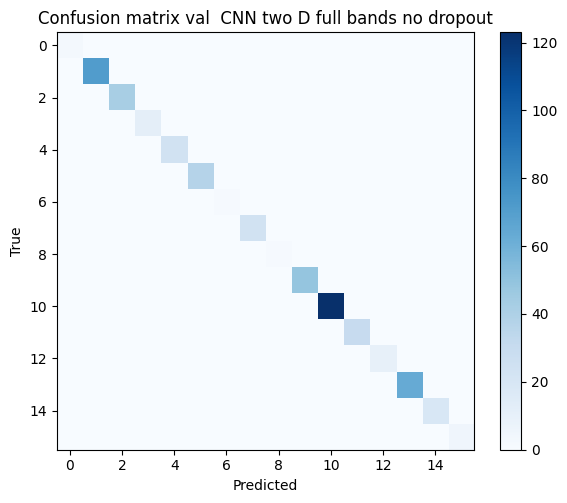

In [8]:
model.load_state_dict(best_state)model.to(DEVICE).eval()# empty linewith torch.no_grad():    v_logits, v_targets = [], []                                    # assign value to v_logits, v_targets    for xb, yb in dl_val:                                           # loop iteration        v_logits.append(model(xb.to(DEVICE)))        v_targets.append(yb.to(DEVICE))    v_logits = torch.cat(v_logits, 0)                               # assign value to v_logits    v_targets = torch.cat(v_targets, 0)                             # assign value to v_targets    vm = metrics_from_logits(v_logits, v_targets, num_classes)      # assign value to vm# empty lineprint("Val accuracy", vm["acc"])print("Val kappa", vm["kappa"])print("Val f1 macro", vm["f1"])# empty lineplt.figure(figsize=(6, 5))                                          # assign value to plt.figure(figsizeplt.imshow(vm["cm"], cmap="Blues")                                  # assign value to plt.imshow(vm["cm"], cmapplt.title("Confusion matrix val  CNN two D full bands no dropout")plt.xlabel("Predicted")plt.ylabel("True")plt.colorbar()plt.tight_layout()plt.savefig(FIGS / "cnn2d_full_confusion_val_nodrop.png", dpi=150)  # assign value to plt.savefig(FIGS / "cnn2d_full_confusion_val_nodrop.png", dpiplt.show()

Test accuracy 0.9975609756097561
Test kappa 0.9972198172511288
Test f1 macro 0.9971931181876853


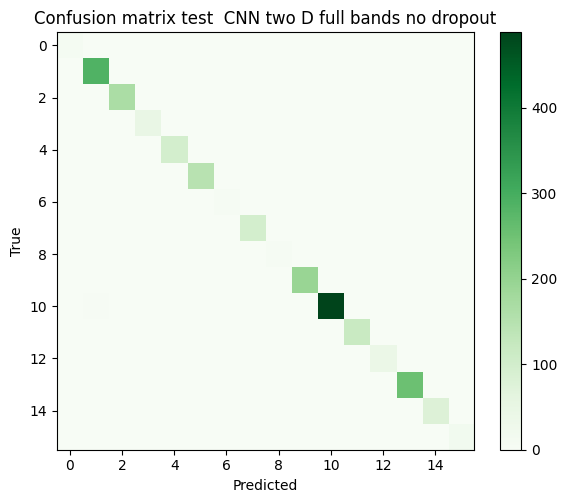


Classification report on test
              precision    recall  f1-score   support

     class_1     1.0000    1.0000    1.0000         9
     class_2     0.9896    1.0000    0.9948       286
     class_3     1.0000    1.0000    1.0000       166
     class_4     1.0000    1.0000    1.0000        47
     class_5     1.0000    1.0000    1.0000        97
     class_6     1.0000    1.0000    1.0000       146
     class_7     1.0000    1.0000    1.0000         5
     class_8     1.0000    1.0000    1.0000        96
     class_9     1.0000    1.0000    1.0000         4
    class_10     1.0000    0.9948    0.9974       194
    class_11     1.0000    0.9939    0.9969       491
    class_12     0.9916    0.9916    0.9916       119
    class_13     1.0000    1.0000    1.0000        41
    class_14     1.0000    1.0000    1.0000       253
    class_15     1.0000    1.0000    1.0000        77
    class_16     0.9500    1.0000    0.9744        19

    accuracy                         0.9976      

In [9]:
with torch.no_grad():    t_logits, t_targets = [], []                                           # assign value to t_logits, t_targets    for xb, yb in dl_test:                                                 # loop iteration        t_logits.append(model(xb.to(DEVICE)))        t_targets.append(yb.to(DEVICE))    t_logits = torch.cat(t_logits, 0)                                      # assign value to t_logits    t_targets = torch.cat(t_targets, 0)                                    # assign value to t_targets    tm = metrics_from_logits(t_logits, t_targets, num_classes)             # assign value to tm# empty lineprint("Test accuracy", tm["acc"])print("Test kappa", tm["kappa"])print("Test f1 macro", tm["f1"])# empty lineplt.figure(figsize=(6, 5))                                                 # assign value to plt.figure(figsizeplt.imshow(tm["cm"], cmap="Greens")                                        # assign value to plt.imshow(tm["cm"], cmapplt.title("Confusion matrix test  CNN two D full bands no dropout")plt.xlabel("Predicted")plt.ylabel("True")plt.colorbar()plt.tight_layout()plt.savefig(FIGS / "cnn2d_full_confusion_test_nodrop.png", dpi=150)        # assign value to plt.savefig(FIGS / "cnn2d_full_confusion_test_nodrop.png", dpiplt.show()# empty linenames = [f"class_{i}" for i in range(1, num_classes + 1)]                  # assign value to namesprint("\nClassification report on test")print(classification_report(t_targets.cpu().numpy(), t_logits.argmax(1).cpu().numpy(),                            target_names=names, digits=4, zero_division=0))  # assign value to target_names

In [16]:
from sklearn.metrics import (                                              # import from sklearn.metrics    accuracy_score,    cohen_kappa_score,    precision_recall_fscore_support,    classification_report,    confusion_matrix,)# empty line                                                                           # convert tensors to numpyy_true = t_targets.cpu().numpy()                                           # assign value to y_truey_pred = t_logits.argmax(1).cpu().numpy()                                  # assign value to y_pred# empty line                                                                           # global metricsoa = accuracy_score(y_true, y_pred)                                        # assign value to oakappa = cohen_kappa_score(y_true, y_pred)                                  # assign value to kappa# empty lineprec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(      # assign value to prec_macro, rec_macro, f1_macro, _    y_true, y_pred, average="macro", zero_division=0                       # assign value to y_true, y_pred, average)prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(  # assign value to prec_weighted, rec_weighted, f1_weighted, _    y_true, y_pred, average="weighted", zero_division=0                    # assign value to y_true, y_pred, average)# empty line                                                                           # per class metricsprec_class, rec_class, f1_class, support_class = precision_recall_fscore_support(  # assign value to prec_class, rec_class, f1_class, support_class    y_true, y_pred, average=None, zero_division=0                          # assign value to y_true, y_pred, average)# empty lineprint("Overall accuracy:", oa)print("Cohen kappa:", kappa)print("Macro precision:", prec_macro)print("Macro recall:", rec_macro)print("Macro f1:", f1_macro)print("Weighted precision:", prec_weighted)print("Weighted recall:", rec_weighted)print("Weighted f1:", f1_weighted)# empty lineprint("\nPer class metrics")for i, (p, r, f1, s) in enumerate(                                         # loop iteration    zip(prec_class, rec_class, f1_class, support_class), start=1           # assign value to zip(prec_class, rec_class, f1_class, support_class), start):    print(        f"Class {i:02d}: "        f"precision={p:.4f}, recall={r:.4f}, f1={f1:.4f}, support={s}"     # assign value to f"precision    )# empty lineprint("\nFull classification report")print(    classification_report(        y_true,        y_pred,        target_names=[f"class_{i}" for i in range(1, num_classes + 1)],    # assign value to target_names        digits=4,                                                          # assign value to digits        zero_division=0,                                                   # assign value to zero_division    ))

Overall accuracy: 0.9975609756097561
Cohen kappa: 0.9972198172511288
Macro precision: 0.9957010009886307
Macro recall: 0.9987707512404251
Macro f1: 0.9971931181876853
Weighted precision: 0.9976005570090303
Weighted recall: 0.9975609756097561
Weighted f1: 0.9975681746746559

Per class metrics
Class 01: precision=1.0000, recall=1.0000, f1=1.0000, support=9
Class 02: precision=0.9896, recall=1.0000, f1=0.9948, support=286
Class 03: precision=1.0000, recall=1.0000, f1=1.0000, support=166
Class 04: precision=1.0000, recall=1.0000, f1=1.0000, support=47
Class 05: precision=1.0000, recall=1.0000, f1=1.0000, support=97
Class 06: precision=1.0000, recall=1.0000, f1=1.0000, support=146
Class 07: precision=1.0000, recall=1.0000, f1=1.0000, support=5
Class 08: precision=1.0000, recall=1.0000, f1=1.0000, support=96
Class 09: precision=1.0000, recall=1.0000, f1=1.0000, support=4
Class 10: precision=1.0000, recall=0.9948, f1=0.9974, support=194
Class 11: precision=1.0000, recall=0.9939, f1=0.9969, su

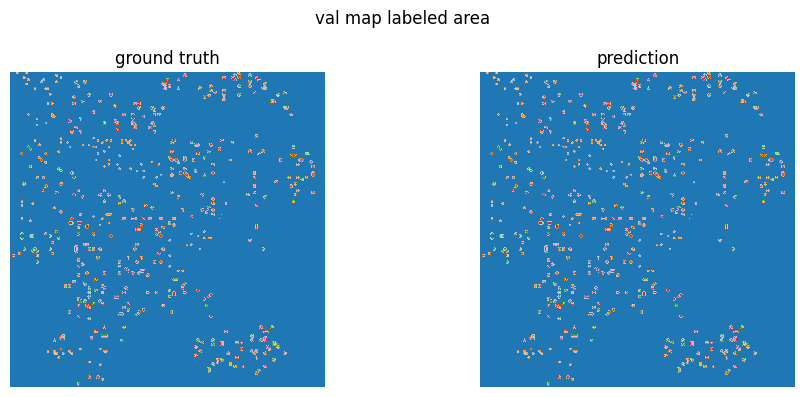

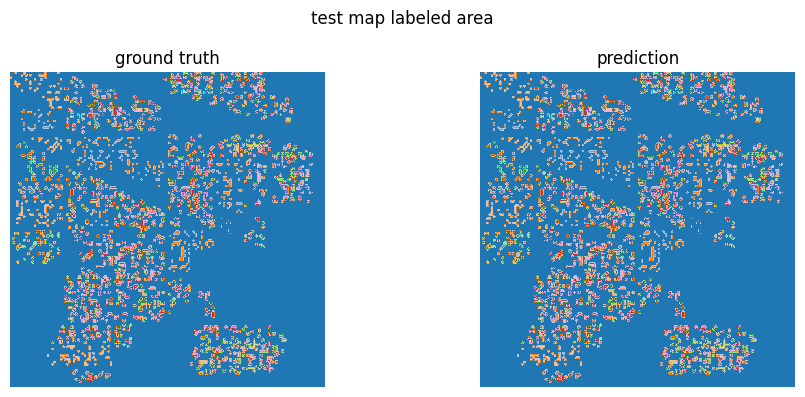

In [10]:
def predict_on_mask(model, ds: PatchDataset2D, mask_map: np.ndarray, num_classes: int) -> np.ndarray:  # define function predict_on_mask    model.eval()    pred_map = np.zeros_like(labels, dtype=np.int64)                       # assign value to pred_map    loader = DataLoader(ds, batch_size=256, shuffle=False)                 # assign value to loader    idx = 0                                                                # assign value to idx    with torch.no_grad():        for xb, _ in loader:                                               # loop iteration            lg = model(xb.to(DEVICE))                                      # assign value to lg            pb = lg.argmax(1).cpu().numpy() + 1                            # assign value to pb            n = pb.shape[0]                                                # assign value to n            for j in range(n):                                             # loop iteration                y, x = ds.centers[idx + j]                                 # assign value to y, x                pred_map[y, x] = pb[j]                                     # assign value to pred_map[y, x]            idx += n                                                       # assign value to idx +    pred_map[~mask_map] = 0                                                # assign value to pred_map[~mask_map]    return pred_map                                                        # return value from function# empty linepred_val_map = predict_on_mask(model, ds_val, mask_val & (labels > 0), num_classes)  # assign value to pred_val_mappred_test_map = predict_on_mask(model, ds_test, mask_test & (labels > 0), num_classes)  # assign value to pred_test_map# empty linedef show_maps(gt, pr, title, fname):                                       # define function show_maps    plt.figure(figsize=(10, 4))                                            # assign value to plt.figure(figsize    plt.subplot(1, 2, 1); plt.imshow(gt, cmap="tab20"); plt.title("ground truth"); plt.axis("off")  # assign value to plt.subplot(1, 2, 1); plt.imshow(gt, cmap    plt.subplot(1, 2, 2); plt.imshow(pr, cmap="tab20"); plt.title("prediction"); plt.axis("off")  # assign value to plt.subplot(1, 2, 2); plt.imshow(pr, cmap    plt.suptitle(title); plt.tight_layout(); plt.savefig(FIGS / fname, dpi=150); plt.show()  # assign value to plt.suptitle(title); plt.tight_layout(); plt.savefig(FIGS / fname, dpi# empty lineshow_maps(np.where(mask_val, labels, 0), pred_val_map, "val map labeled area", "cnn2d_full_val_maps_nodrop.png")show_maps(np.where(mask_test, labels, 0), pred_test_map, "test map labeled area", "cnn2d_full_test_maps_nodrop.png")

In [14]:
                                                                           # One cell to define CNN2D_NoDrop and print a detailed text summary# empty line!pip install -q torchinfo# empty lineimport torch                                                               # import torch libraryimport torch.nn as nn                                                      # import torch.nn libraryfrom torchinfo import summary                                              # import from torchinfo# empty lineclass CNN2D_NoDrop(nn.Module):                                             # define class CNN2D_NoDrop    def __init__(self, in_ch: int, num_classes: int, reduce_to: int | None = None):  # assign value to def __init__(self, in_ch: int, num_classes: int, reduce_to: int | None        super().__init__()        c_in = in_ch                                                       # assign value to c_in        layers = []                                                        # assign value to layers# empty line                                                                           # optional learned bottleneck with one by one conv        if reduce_to is not None:                                          # conditional statement            layers += [                                                    # assign value to layers +                nn.Conv2d(c_in, reduce_to, kernel_size=1, padding=0),      # assign value to nn.Conv2d(c_in, reduce_to, kernel_size                nn.ReLU(inplace=True),                                     # assign value to nn.ReLU(inplace                nn.BatchNorm2d(reduce_to),            ]            c_in = reduce_to                                               # assign value to c_in# empty line                                                                           # block one        layers += [                                                        # assign value to layers +            nn.Conv2d(c_in, 32, kernel_size=3, padding=1),                 # assign value to nn.Conv2d(c_in, 32, kernel_size            nn.ReLU(inplace=True),                                         # assign value to nn.ReLU(inplace            nn.BatchNorm2d(32),            nn.Conv2d(32, 32, kernel_size=3, padding=1),                   # assign value to nn.Conv2d(32, 32, kernel_size            nn.ReLU(inplace=True),                                         # assign value to nn.ReLU(inplace            nn.BatchNorm2d(32),            nn.MaxPool2d(2),        ]                                                                           # block two        layers += [                                                        # assign value to layers +            nn.Conv2d(32, 64, kernel_size=3, padding=1),                   # assign value to nn.Conv2d(32, 64, kernel_size            nn.ReLU(inplace=True),                                         # assign value to nn.ReLU(inplace            nn.BatchNorm2d(64),            nn.Conv2d(64, 64, kernel_size=3, padding=1),                   # assign value to nn.Conv2d(64, 64, kernel_size            nn.ReLU(inplace=True),                                         # assign value to nn.ReLU(inplace            nn.BatchNorm2d(64),            nn.MaxPool2d(2),        ]                                                                           # block three        layers += [                                                        # assign value to layers +            nn.Conv2d(64, 128, kernel_size=3, padding=1),                  # assign value to nn.Conv2d(64, 128, kernel_size            nn.ReLU(inplace=True),                                         # assign value to nn.ReLU(inplace            nn.BatchNorm2d(128),            nn.Conv2d(128, 128, kernel_size=3, padding=1),                 # assign value to nn.Conv2d(128, 128, kernel_size            nn.ReLU(inplace=True),                                         # assign value to nn.ReLU(inplace            nn.BatchNorm2d(128),            nn.AdaptiveAvgPool2d(1),        ]# empty line        self.feat = nn.Sequential(*layers)                                 # assign value to self.feat        self.head = nn.Sequential(                                         # assign value to self.head            nn.Flatten(),            nn.Linear(128, 256),            nn.ReLU(inplace=True),                                         # assign value to nn.ReLU(inplace            nn.Linear(256, num_classes),        )# empty line    def forward(self, x):                                                  # define function forward        z = self.feat(x)                                                   # assign value to z        return self.head(z)                                                # return value from function# empty line# empty lineB = 200                                                                    # change to your band countnum_classes = 16                                                           # change to your class countDEVICE = "cuda" if torch.cuda.is_available() else "cpu"                    # assign value to DEVICE# empty linemodel = CNN2D_NoDrop(in_ch=B, num_classes=num_classes, reduce_to=None).to(DEVICE)  # assign value to model# empty lineprint("Model summary")summary(model, input_size=(1, B, 15, 15))                                  # assign value to summary(model, input_size

Model summary



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Layer (type:depth-idx)                   Output Shape              Param #
CNN2D_NoDrop                             [1, 16]                   --
├─Sequential: 1-1                        [1, 128, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 32, 15, 15]           57,632
│    └─ReLU: 2-2                         [1, 32, 15, 15]           --
│    └─BatchNorm2d: 2-3                  [1, 32, 15, 15]           64
│    └─Conv2d: 2-4                       [1, 32, 15, 15]           9,248
│    └─ReLU: 2-5                         [1, 32, 15, 15]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 15, 15]           64
│    └─MaxPool2d: 2-7                    [1, 32, 7, 7]             --
│    └─Conv2d: 2-8                       [1, 64, 7, 7]             18,496
│    └─ReLU: 2-9                         [1, 64, 7, 7]             --
│    └─BatchNorm2d: 2-10                 [1, 64, 7, 7]             128
│    └─Conv2d: 2-11                      [1, 64, 7, 7]             36,928

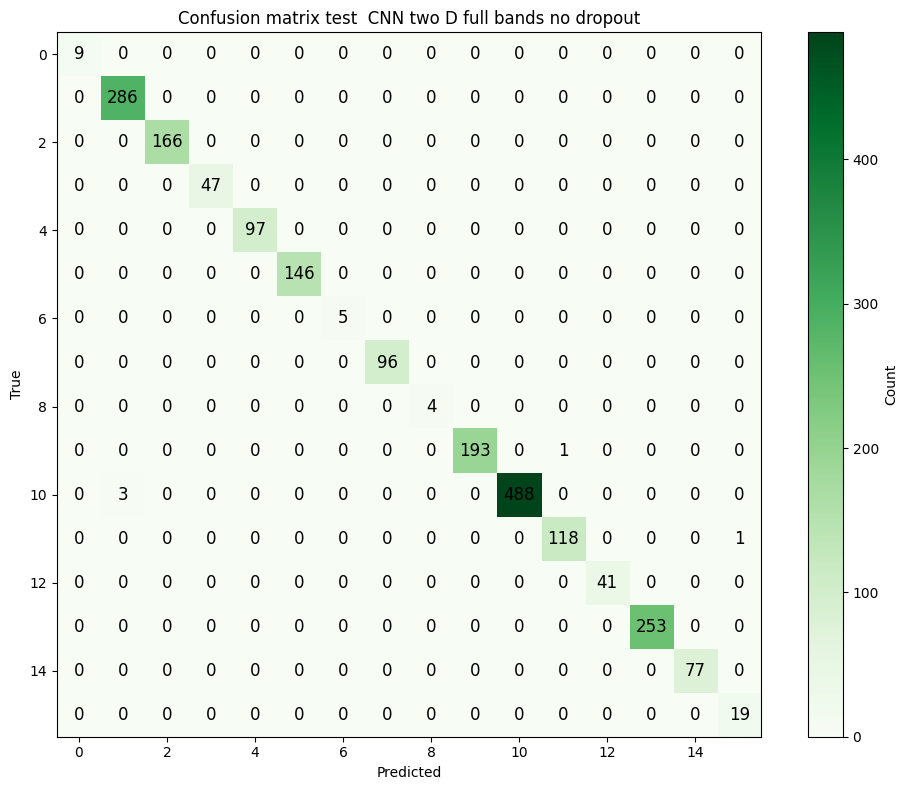

In [19]:
cm = tm["cm"]                                                           # assign value to cm# empty linefig, ax = plt.subplots(figsize=(10, 8))                                 # bigger figureim = ax.imshow(cm, cmap="Greens")                                       # assign value to im# empty lineax.set_title("Confusion matrix test  CNN two D full bands no dropout")ax.set_xlabel("Predicted")ax.set_ylabel("True")# empty line                                                                        # add a color barcbar = plt.colorbar(im, ax=ax)                                          # assign value to cbarcbar.ax.set_ylabel("Count")# empty line                                                                        # show values inside each cellnum_classes = cm.shape[0]                                               # assign value to num_classesfor i in range(num_classes):                                            # loop iteration    for j in range(num_classes):                                        # loop iteration        value = int(cm[i, j])                                           # assign value to value        ax.text(            j,            i,            str(value),            ha="center",                                                # assign value to ha            va="center",                                                # assign value to va            fontsize=12,                                                # assign value to fontsize            color="black",                                              # assign value to color        )# empty lineplt.tight_layout()plt.savefig(FIGS / "cnn2d_full_confusion_test_nodrop.png", dpi=150)     # assign value to plt.savefig(FIGS / "cnn2d_full_confusion_test_nodrop.png", dpiplt.show()

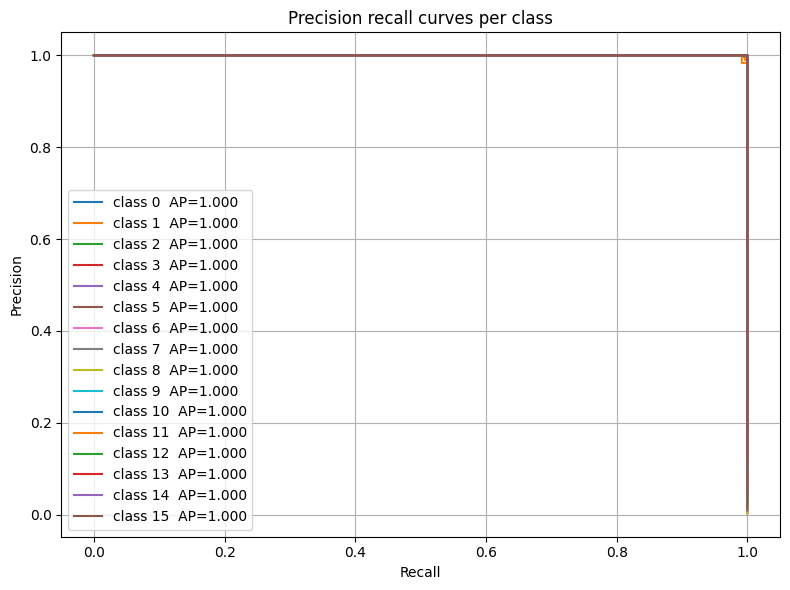

In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score  # import from sklearn.metrics# empty lineprobs = torch.softmax(t_logits, dim=1).cpu().numpy()                       # assign value to probsy_true = t_targets.cpu().numpy()                                           # assign value to y_true# empty lineplt.figure(figsize=(8, 6))                                                 # assign value to plt.figure(figsize# empty linefor c in range(num_classes):                                               # loop iteration                                                                           # binary labels for this class    y_c = (y_true == c).astype(int)                                        # assign value to y_c    y_score_c = probs[:, c]                                                # assign value to y_score_c# empty line    precision_c, recall_c, _ = precision_recall_curve(y_c, y_score_c)      # assign value to precision_c, recall_c, _    ap_c = average_precision_score(y_c, y_score_c)                         # assign value to ap_c# empty line    plt.plot(recall_c, precision_c, label=f"class {c}  AP={ap_c:.3f}")     # assign value to plt.plot(recall_c, precision_c, label# empty lineplt.xlabel("Recall")plt.ylabel("Precision")plt.title("Precision recall curves per class")plt.legend()plt.grid(True)plt.tight_layout()plt.savefig(FIGS / "precision_recall_curve_multiclass.png", dpi=150)       # assign value to plt.savefig(FIGS / "precision_recall_curve_multiclass.png", dpiplt.show()

In [23]:
epochs = [h["epoch"] for h in history]                      # assign value to epochstrain_losses = [h["train_loss"] for h in history]           # assign value to train_lossesval_accs = [h["val_acc"] for h in history]                  # assign value to val_accsval_f1s = [h["val_f1"] for h in history]                    # assign value to val_f1s

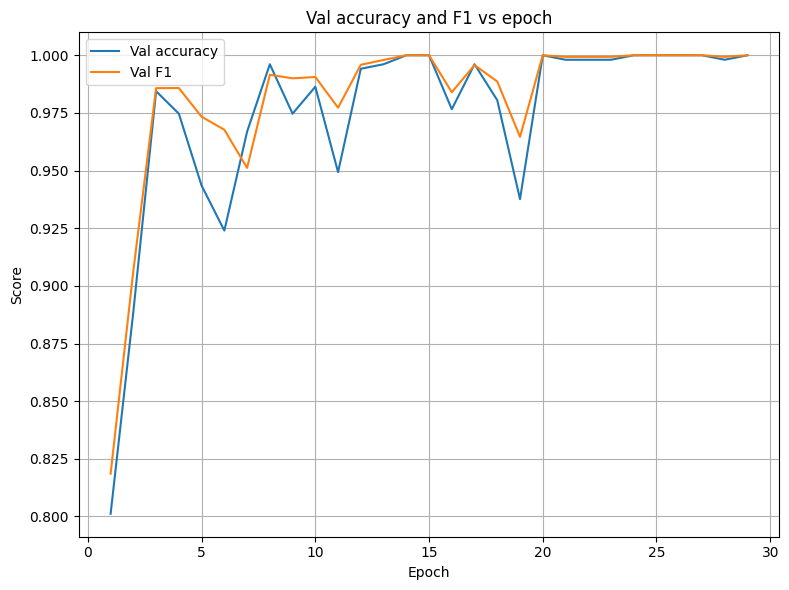

In [24]:
plt.figure(figsize=(8, 6))                                  # assign value to plt.figure(figsizeplt.plot(epochs, val_accs, label="Val accuracy")            # assign value to plt.plot(epochs, val_accs, labelplt.plot(epochs, val_f1s, label="Val F1")                   # assign value to plt.plot(epochs, val_f1s, labelplt.xlabel("Epoch")plt.ylabel("Score")plt.title("Val accuracy and F1 vs epoch")plt.grid(True)plt.legend()plt.tight_layout()# empty lineplt.savefig(FIGS / "val_metrics_vs_epoch.png", dpi=150)     # assign value to plt.savefig(FIGS / "val_metrics_vs_epoch.png", dpiplt.show()

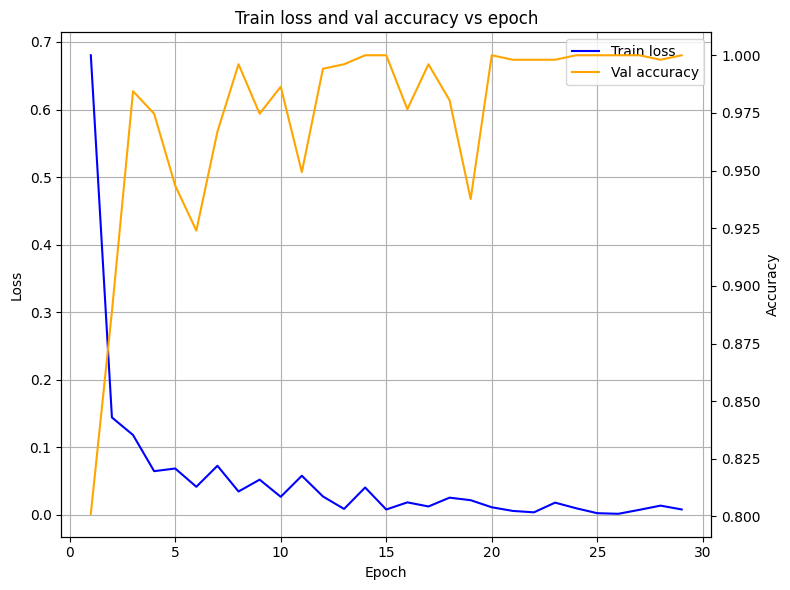

In [27]:
import matplotlib.pyplot as plt                                          # import matplotlib.pyplot library# empty lineepochs = [h["epoch"] for h in history]                                   # assign value to epochstrain_losses = [h["train_loss"] for h in history]                        # assign value to train_lossesval_accs = [h["val_acc"] for h in history]                               # assign value to val_accs# empty linefig, ax1 = plt.subplots(figsize=(8, 6))                                  # assign value to fig, ax1# empty line                                                                         # loss in bluelns1 = ax1.plot(epochs, train_losses, color="blue", label="Train loss")  # assign value to lns1ax1.set_xlabel("Epoch")ax1.set_ylabel("Loss")ax1.grid(True)# empty line                                                                         # accuracy in orangeax2 = ax1.twinx()                                                        # assign value to ax2lns2 = ax2.plot(epochs, val_accs, color="orange", label="Val accuracy")  # assign value to lns2ax2.set_ylabel("Accuracy")# empty line                                                                         # legendlns = lns1 + lns2                                                        # assign value to lnslabels = [l.get_label() for l in lns]                                    # assign value to labelsax1.legend(lns, labels, loc="best")                                      # assign value to ax1.legend(lns, labels, loc# empty lineplt.title("Train loss and val accuracy vs epoch")plt.tight_layout()plt.savefig(FIGS / "loss_accuracy_combined_vs_epoch.png", dpi=150)       # assign value to plt.savefig(FIGS / "loss_accuracy_combined_vs_epoch.png", dpiplt.show()